Epoch 010, Loss: 59.2928, Test Acc: 0.3333
Epoch 020, Loss: 77.5254, Test Acc: 0.1667
Epoch 030, Loss: 23.7402, Test Acc: 0.1667
Epoch 040, Loss: 18.2665, Test Acc: 0.1667
Epoch 050, Loss: 8.2611, Test Acc: 0.1667
Epoch 060, Loss: 5.0348, Test Acc: 0.3333
Epoch 070, Loss: 1.5002, Test Acc: 0.5000
Epoch 080, Loss: 1.5841, Test Acc: 0.3333
Epoch 090, Loss: 0.4634, Test Acc: 0.5000
Epoch 100, Loss: 0.1216, Test Acc: 0.3333


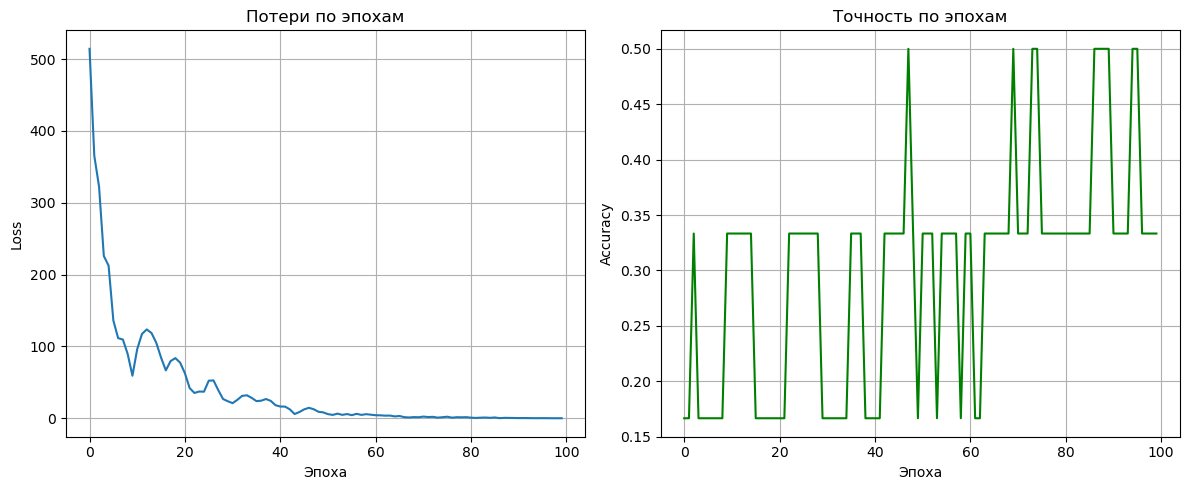

'\n#t-SNE визуализация после первого слоя GCN\n\nfrom sklearn.manifold import TSNE\nimport matplotlib.pyplot as plt\n\n# Получим скрытые представления (после первого слоя GCN)\nmodel.eval()\nwith torch.no_grad():\n    x_hidden = model.conv1(data.x, data.edge_index)\n    x_hidden = F.relu(x_hidden)  # [num_nodes, hidden_dim]\n\n# Применим t-SNE только к пользователям (первые 20 узлов)\nx_user = x_hidden[:num_users].cpu().numpy()\ny_user = y.cpu().numpy()\n\ntsne = TSNE(n_components=2, random_state=42, perplexity=5)\nx_tsne = tsne.fit_transform(x_user)\n\n# Визуализация\nplt.figure(figsize=(8, 6))\nscatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_user, cmap=\'tab10\', s=60)\nplt.title("t-SNE визуализация скрытых признаков пользователей")\nplt.colorbar(scatter, label="Роль пользователя (y)")\nplt.grid(True)\nplt.show()\n'

In [13]:
# GCN + LSTM гибридная модель для анализа поведения пользователей
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# === Загрузка данных ===
edges_df = pd.read_csv("data/edges2.csv", parse_dates=["timestamp"])
nodes_df = pd.read_csv("data/nodes2.csv")
resources_df = pd.read_csv("data/resources2.csv")

# === GCN часть: признаки узлов и edge_index ===
le_role = LabelEncoder()
nodes_df['role_encoded'] = le_role.fit_transform(nodes_df['role'])
nodes_df['last_login_time'] = pd.to_datetime(nodes_df['last_login_time'])
ref_date = pd.Timestamp("2025-05-07")
nodes_df['days_since_login'] = (ref_date - nodes_df['last_login_time']).dt.days

user_features = nodes_df[['role_encoded', 'login_count', 'access_level', 'session_time', 'var_activity', 'days_since_login']].values

resources_df['resource_type_encoded'] = LabelEncoder().fit_transform(resources_df['resource_type'])
res_base_features = resources_df[['resource_type_encoded', 'access_count_last_month', 'importance', 'access_level']].values
res_padded = np.hstack([res_base_features, np.zeros((res_base_features.shape[0], 2))])

x_combined = np.vstack([user_features, res_padded])
x = torch.tensor(x_combined, dtype=torch.float)

offset = nodes_df.shape[0]
sources = edges_df['source_user'].astype(int).values
targets = edges_df['target_resource'].astype(int).values + offset
edge_index = torch.tensor(np.vstack([sources, targets]), dtype=torch.long)

y = torch.tensor(nodes_df['role_encoded'].values, dtype=torch.long)

data = Data(x=x, edge_index=edge_index)

# === LSTM часть: последовательности действий ===
edges_df = edges_df.dropna(subset=['event_type'])
edges_df['event_type_id'] = LabelEncoder().fit_transform(edges_df['event_type'])
edges_df['hour'] = edges_df['timestamp'].dt.hour
edges_df['dayofweek'] = edges_df['timestamp'].dt.dayofweek

features = ['hour', 'dayofweek', 'event_type_id', 'weight']
sequences = []
user_ids = sorted(edges_df['source_user'].unique())

for user_id in user_ids:
    user_seq = edges_df[edges_df['source_user'] == user_id].sort_values('timestamp')[features].values
    sequences.append(user_seq)

max_len = max(len(seq) for seq in sequences)
num_features = len(features)
padded = np.zeros((len(sequences), max_len, num_features))
for i, seq in enumerate(sequences):
    padded[i, :len(seq), :] = seq

lstm_input_tensor = torch.tensor(padded, dtype=torch.float)

# === Маски и данные ===
num_users = user_features.shape[0]
train_idx, test_idx = train_test_split(np.arange(len(user_ids)), test_size=0.3, stratify=y, random_state=42)
train_mask = torch.zeros(len(user_ids), dtype=torch.bool)
test_mask = torch.zeros(len(user_ids), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

# === Гибридная модель ===
class GCN_LSTM_Hybrid(nn.Module):
    def __init__(self, gcn_in, gcn_hidden, lstm_in, lstm_hidden, out_dim):
        super().__init__()
        self.gcn = GCNConv(gcn_in, gcn_hidden)
        self.lstm = nn.LSTM(input_size=lstm_in, hidden_size=lstm_hidden, batch_first=True)
        self.fc = nn.Linear(gcn_hidden + lstm_hidden, out_dim)

    def forward(self, data, sequences):
        x_gcn = F.relu(self.gcn(data.x, data.edge_index))
        x_users = x_gcn[:sequences.size(0)]
        lstm_out, _ = self.lstm(sequences)
        lstm_last = lstm_out[:, -1, :]
        x_combined = torch.cat([x_users, lstm_last], dim=1)
        return self.fc(x_combined)

model = GCN_LSTM_Hybrid(
    gcn_in=6, gcn_hidden=16,
    lstm_in=4, lstm_hidden=16,
    out_dim=len(torch.unique(y))
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data, lstm_input_tensor)
    loss = criterion(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data, lstm_input_tensor)
        pred = out.argmax(dim=1)
        correct = (pred[test_mask] == y[test_mask]).sum().item()
        return correct / test_mask.sum().item()

losses = []
accuracies = []

for epoch in range(1, 101):
    loss = train()
    acc = test()
    losses.append(loss)
    accuracies.append(acc)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}")


#Визуализация обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title("Потери по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='green')
plt.title("Точность по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()





